In [3]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets
import torch.utils.data as data

In [4]:
import deeptriplet.models
import deeptriplet.datasets

In [6]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True
1


## Load VOC2012 dataset

In [7]:
valset = deeptriplet.datasets.PascalDataset(pascal_root="/srv/glusterfs/yardima/datasets/voc12/VOCdevkit/VOC2012",
                                            split_file="/home/yardima/Python/experiments/pascal_split/val_obj.txt",
                                            normalize_imagenet=True,
                                            augment=False,
                                            pad_zeros=True,
                                            downsample_label=1)

valloader = data.DataLoader(valset,
                                batch_size=1,
                                num_workers=2,
                                shuffle=False)

trainset = deeptriplet.datasets.PascalDataset(pascal_root="/srv/glusterfs/yardima/datasets/voc12/VOCdevkit/VOC2012",
                        split_file="/home/yardima/Python/experiments/pascal_split/train_obj.txt",
                        normalize_imagenet=True,
                        augment=True,
                        pad_zeros=True,
                        downsample_label=8,
                        scale_low=0.8,
                        scale_high=1.2)

trainloader = data.DataLoader(trainset,
                                batch_size=10,
                                num_workers=4,
                                shuffle=False)

## Load trained embedding model

In [8]:
model_path_random = "/srv/glusterfs/yardima/runs/deeplabv3_plus/triplet-aug-spatial/run_7/models/deeplabv3p-triplet-aug-spatial-last_epoch-79.pth"
d1 = torch.load(model_path_random)

from deeptriplet.models.deeplabv3p.deeplab_spatial_last import DeepLabSpatialLate
net = DeepLabSpatialLate(backbone='resnet', num_classes=50, dynamic_coordinates=False, sync_bn=True, freeze_bn=False)
net = net.cuda()
net.load_state_dict(d1)

net = net.eval().cuda();

n_channels = 50

In [9]:
# model_path_random = "/srv/glusterfs/yardima/runs/deeplabv3_plus/triplet-aug-spatial/run_7/models/deeplabv3p-triplet-aug-spatial-last_epoch-79.pth"
# d1 = torch.load(model_path_random)

# from modeling.deeplab import *

# net = DeepLab(backbone='resnet', output_stride=16, num_classes=50, sync_bn=True, freeze_bn=False)
# net = net.cuda()
# net.load_state_dict(d1)

# net = net.eval().cuda();

# n_channels = 50


## Determine most difficult images

In [10]:
import deeptriplet.triplet
from deeptriplet.datasets.subdataset import SubDataset

loss_fn_pretrain = deeptriplet.triplet.RandomTripletPreselected(n_batch=1, n_triplets=15000)

pretrainset = deeptriplet.datasets.PascalDatasetRandomTriplet(pascal_root="/srv/glusterfs/yardima/datasets/voc12/VOCdevkit/VOC2012",
                                            split_file="/home/yardima/Python/experiments/pascal_split/train_obj.txt",
                                            n_triplets=15000,
                                            normalize_imagenet=True,
                                            augment=False,
                                            pad_zeros=True,
                                            downsample_label=1)

In [11]:
errors = []
with torch.no_grad():
    for i, d in enumerate(pretrainset):
        img, idx = d
        img = img.cuda().unsqueeze(0)
        idx = idx.cuda().unsqueeze(0)

        outputs = net.forward(img)
        loss = loss_fn_pretrain.compute_loss(outputs, idx).item()

        errors.append((i, loss))

In [12]:
errors = sorted(errors, key=lambda tup: tup[1])

<IPython.core.display.Javascript object>


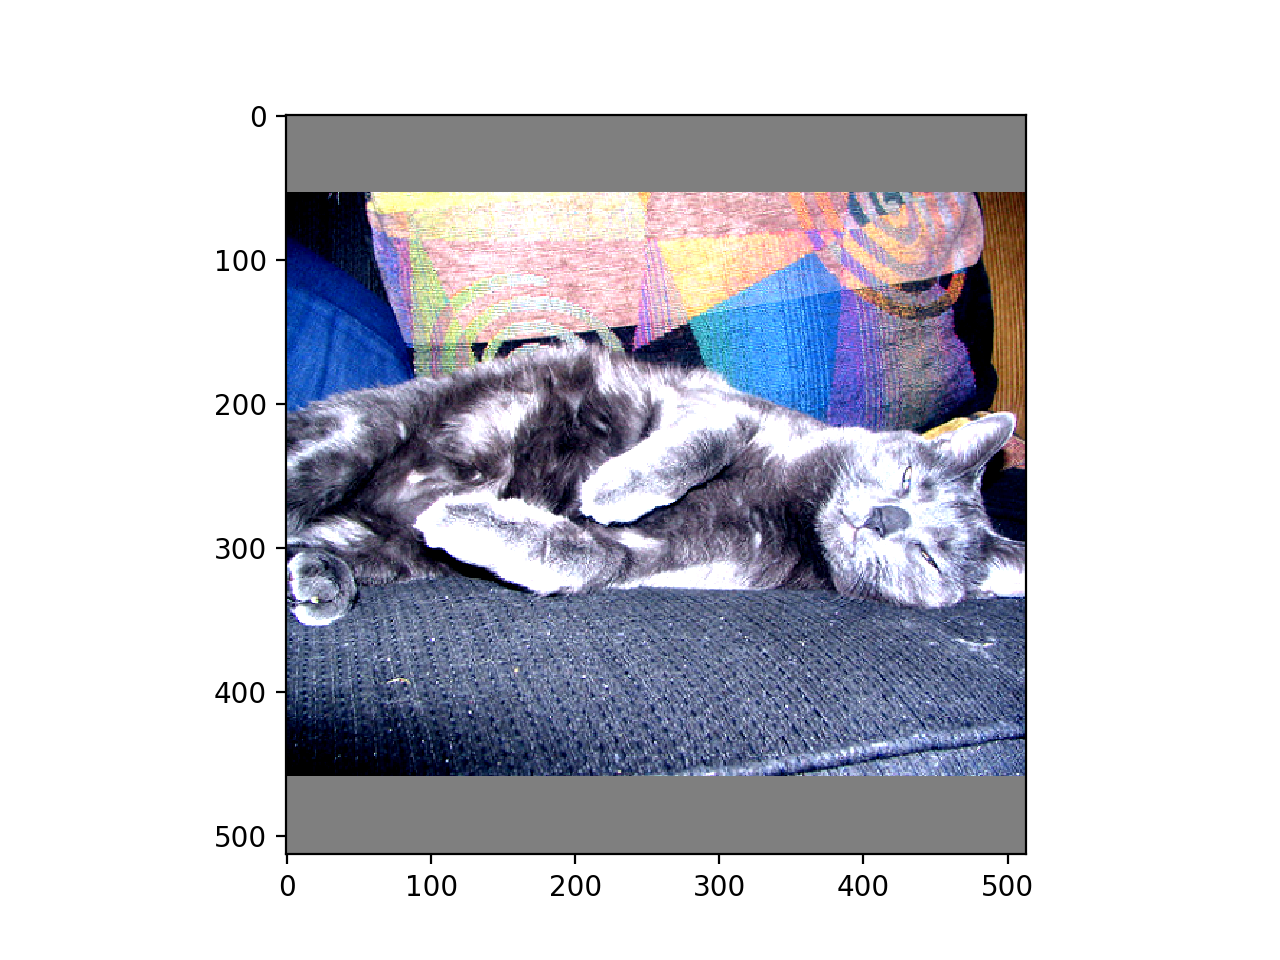

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [13]:
plt.figure()
img = trainset[errors[-1][0]][0]
plt.imshow(np.transpose(img.numpy(), axes=[1,2,0]) / 2 + 0.5)

In [14]:
n_samples = 500
indices = [e[0] for e in errors[-n_samples:]]

In [15]:
trainset_main = deeptriplet.datasets.PascalDatasetRandomTripletAugmented(
                        pascal_root="/srv/glusterfs/yardima/datasets/voc12/VOCdevkit/VOC2012",
                        split_file="/home/yardima/Python/experiments/pascal_split/train_obj.txt",
                        n_triplets=14000)

trainset = deeptriplet.datasets.SubDataset(parent_dataset=trainset_main, 
                                             indices=indices)

trainloader = data.DataLoader(trainset,
                                batch_size=8,
                                num_workers=4,
                                shuffle=True)